In [1]:
import collections
import dataclasses

import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

from scripture_graph import graph_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
graph = nx.read_graphml('../../scripture_graph.graphml')

In [3]:
nx.reciprocity(graph)

0.824880967981479

In [4]:
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 41995
Number of edges: 45786
Average in degree:   1.0903
Average out degree:   1.0903


In [5]:
print(nx.number_weakly_connected_components(graph))
print(nx.number_strongly_connected_components(graph))

24015
26773


# Weakly Connected Components

In [6]:
sizes = []
for component in nx.weakly_connected_components(graph):
    sizes.append(len(component))
sizes = np.asarray(sizes)

x = np.unique(sizes)
y = np.asarray([np.count_nonzero(sizes == size) for size in x])
df = pd.DataFrame({'size': x, 'count': y})
df

,size,count
0,1,22250
1,2,1161
2,3,342
3,4,124
4,5,64
5,6,23
6,7,12
7,8,15
8,9,7
9,10,7


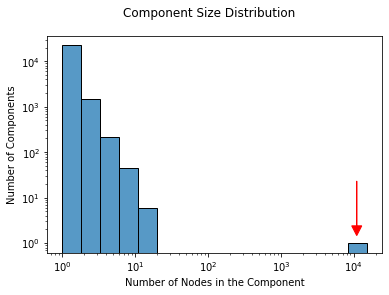

In [121]:
fig, ax = subplots()
sns.histplot(sizes, log_scale=True, ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Number of Components')
ax.set_xlabel('Number of Nodes in the Component')
fig.suptitle('Component Size Distribution')
# Add an arrow.
ax.arrow(0.925, 0.33, 0, -0.25, transform=ax.transAxes, head_width=0.03, color='red', length_includes_head=True)
fig.savefig('component-size.png', dpi=300, bbox_inches='tight')

In [8]:
# Prune the graph to the largest strongly connected component.
# How many edges does it have?
nodes = None
for component in nx.weakly_connected_components(graph):
    if len(component) > 1000:
        nodes = component
        break
subgraph = nx.subgraph(graph, nodes)
print(graph.number_of_nodes())
print(graph.number_of_edges())
print(subgraph.number_of_nodes())
print(subgraph.number_of_edges())

41995
45786
14988
39816


In [9]:
# Percentage of singletons (no incoming *or* outgoing edges)
count = 0
for node, degree in graph.degree():
    if degree == 0:
        count += 1
print(count, count / graph.number_of_nodes())

22250 0.5298249791641862


In [10]:
# Percentage of non-singletons in the largest component.
subgraph.number_of_nodes() / count

0.6736179775280899

# Centrality

In [11]:
def top_k(scores, k=None):
    """Return the top k values from a dict of node or edge scores."""
    keys, values = zip(*scores.items())
    keys = np.asarray(keys)
    values = np.asarray(values)
    # Assign ranks.
    ranks = scipy.stats.rankdata(-1 * values, method='min')
    sort = np.argsort(ranks)
    if not k:
        k = len(sort)
    rval = {}
    for i in range(k):
        rval[keys[sort][i]] = (values[sort][i], ranks[sort][i])
    return rval

In [12]:
# Find ranks of the unique verses.
# NOTE: We are using the main subgraph here, not the full grah.
degree_ranks = top_k(nx.in_degree_centrality(subgraph))
page_ranks = top_k(nx.pagerank(subgraph))

k = 10
for degree_key in list(degree_ranks.keys())[:k]:
    print(degree_key, degree_ranks[degree_key], page_ranks[degree_key])
for page_key in list(page_ranks.keys())[:k]:
    print(page_key, degree_ranks[page_key], page_ranks[page_key])

D&C 1:38 (0.0018015613531727496, 1) (0.0005748630666542338, 1)
D&C 17:1 (0.0018015613531727496, 1) (0.00046049633222370955, 8)
1 Ne. 17:35 (0.0016681123640488423, 3) (0.0005628340031874453, 2)
Hel. 12:3 (0.0016681123640488423, 3) (0.000519579398790232, 4)
D&C 1:14 (0.0016013878694868886, 5) (0.0004719735306604833, 7)
1 Ne. 19:10 (0.001534663374924935, 6) (0.0003447754720184428, 27)
2 Ne. 25:20 (0.001534663374924935, 6) (0.0003763835759739454, 18)
Moses 6:57 (0.001534663374924935, 6) (0.0004545115901967482, 10)
D&C 1:16 (0.0014012143858010276, 9) (0.00037845860172870265, 17)
D&C 88:63 (0.0014012143858010276, 9) (0.00046025865469352634, 9)
D&C 1:38 (0.0018015613531727496, 1) (0.0005748630666542338, 1)
1 Ne. 17:35 (0.0016681123640488423, 3) (0.0005628340031874453, 2)
Mosiah 4:26 (0.0011343164075532128, 22) (0.0005542445180812482, 3)
Hel. 12:3 (0.0016681123640488423, 3) (0.000519579398790232, 4)
2 Ne. 9:37 (0.0008006939347434443, 110) (0.0004848246946225574, 5)
2 Ne. 9:28 (0.00133448989123

In [13]:
# Plot correlation of degree and pagerank scores.
rows = []
for key, value in degree_ranks.items():
    rows.append({
        'verse': key, 
        'degree': value[0], 
        'degree_rank': value[1],
        'degree_count': subgraph.in_degree(key),
        'pagerank': page_ranks[key][0],
        'pagerank_rank': page_ranks[key][1],
    })
df = pd.DataFrame(rows)
df.head()

,verse,degree,degree_rank,degree_count,pagerank,pagerank_rank
0,D&C 1:38,0.001802,1,27,0.000575,1
1,D&C 17:1,0.001802,1,27,0.000460,8
2,1 Ne. 17:35,0.001668,3,25,0.000563,2
3,Hel. 12:3,0.001668,3,25,0.000520,4
4,D&C 1:14,0.001601,5,24,0.000472,7


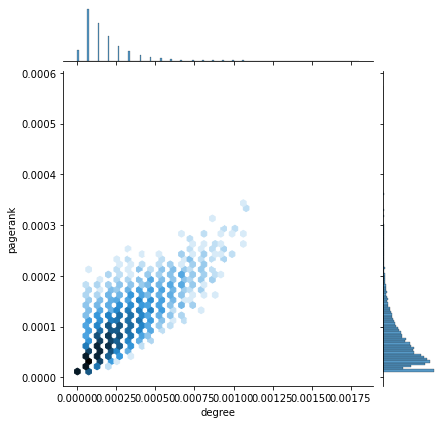

In [14]:
sns.jointplot(x='degree', y='pagerank', data=df, kind='hex', mincnt=1, bins='log')

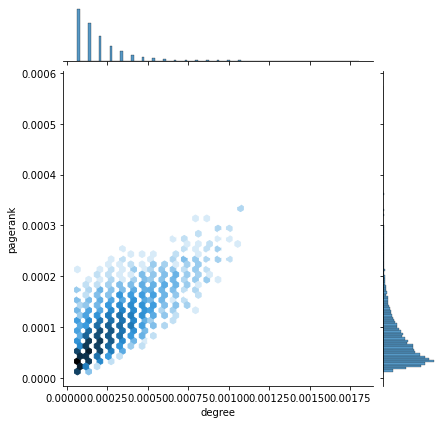

In [15]:
mask = (df.degree > 0)
sns.jointplot(x='degree', y='pagerank', data=df[mask], kind='hex', mincnt=1, bins='log')

In [16]:
# Calculate the rank correlation; we don't necessarily expect/need the relationship to be linear (i.e. pearson)
t, _ = scipy.stats.kendalltau(df.degree.values, df.pagerank.values)
r, _ = scipy.stats.spearmanr(df.degree.values, df.pagerank.values)
print(t, r**2)

0.7274001624498954 0.7403013714868051


In [17]:
# Now mask the zeros and repeat
mask = (df.degree > 0)
t, _ = scipy.stats.kendalltau(df[mask].degree.values, df[mask].pagerank.values)
r, _ = scipy.stats.spearmanr(df[mask].degree.values, df[mask].pagerank.values)
print(t, r**2)

0.6857747608199917 0.6867735579659244


In [18]:
subgraph.in_degree('2 Ne. 9:37')

12

In [19]:
subgraph.in_degree('2 Ne. 9:28')

20

In [20]:
page_ranks['2 Ne. 9:37']

(0.0004848246946225574, 5)

In [21]:
page_ranks['2 Ne. 9:28']

(0.00047867049217186874, 6)

In [22]:
scores = []
for source, _ in subgraph.in_edges('2 Ne. 9:37'):
    scores.append((source, page_ranks[source], subgraph.out_degree(source)))
ranks = [x[1][1] for x in scores]
total = sum([x[1][0] / x[2] for x in scores])
print(total, np.mean(ranks), np.median(ranks))
scores

0.0006024807288538965 7010.416666666667 5359.0


[('2 Chr. 25:15', (1.1344745861548866e-05, 14023), 1),
 ('Deut. 31:16', (9.636416205185575e-05, 3079), 6),
 ('Ex. 34:14', (5.388508614152072e-05, 7511), 6),
 ('Ezek. 18:6', (9.501978701842491e-05, 3180), 4),
 ('Isa. 41:24', (0.0004381816393310352, 11), 1),
 ('Jer. 17:2', (1.1344745861548866e-05, 14023), 2),
 ('Judg. 2:17', (8.322911430310776e-05, 4137), 6),
 ('Lev. 19:4', (1.9709490710576726e-05, 13589), 3),
 ('Ps. 16:4', (1.8968199793021285e-05, 13689), 5),
 ('Alma 31:1', (6.0665416203765885e-05, 6581), 4),
 ('Alma 7:6', (0.00012628225365870994, 1575), 3),
 ('Hel. 6:31', (0.00010194032856325827, 2727), 6)]

In [23]:
scores = []
for source, _ in subgraph.in_edges('2 Ne. 9:28'):
    scores.append((source, page_ranks[source], subgraph.out_degree(source)))
ranks = [x[1][1] for x in scores]
total = sum([x[1][0] / x[2] for x in scores])
print(total, np.mean(ranks), np.median(ranks))
scores

0.0005510264529943011 5391.65 3652.5


[('Eccl. 10:12', (9.531304292500204e-05, 3158), 4),
 ('Eccl. 4:5', (3.1668573985467875e-05, 11576), 1),
 ('Eccl. 8:17', (5.442964669452996e-05, 7442), 3),
 ('Ezek. 28:5', (9.057378262998847e-05, 3515), 2),
 ('Isa. 9:9', (3.1668573985467875e-05, 11576), 1),
 ('Jer. 8:8', (5.10286444838217e-05, 7917), 2),
 ('Job 11:12', (3.1668573985467875e-05, 11576), 1),
 ('Luke 16:15', (8.71972870425902e-05, 3790), 3),
 ('Prov. 14:6', (9.307918504346416e-05, 3312), 4),
 ('Prov. 15:22', (0.00010748452539004232, 2403), 5),
 ('Prov. 23:4', (3.1668573985467875e-05, 11576), 2),
 ('Rom. 1:22', (3.1668573985467875e-05, 11576), 1),
 ('2 Ne. 19:17', (0.0001835587971246327, 434), 9),
 ('2 Ne. 26:20', (0.0002395160872612998, 133), 17),
 ('2 Ne. 28:4', (7.32257191250988e-05, 5103), 3),
 ('Alma 28:13', (5.972372437040429e-05, 6704), 2),
 ('Alma 37:12', (0.00014117650290980895, 1121), 6),
 ('D&C 35:7', (0.00011525606126366558, 2022), 5),
 ('D&C 76:9', (0.00010341406251798867, 2641), 2),
 ('Jacob 4:10', (0.000209220

In [24]:
scores = []
for source, _ in subgraph.in_edges('D&C 1:14'):
    scores.append((source, page_ranks[source]))
ranks = [x[1][1] for x in scores]
total = sum([x[1][0] for x in scores])
print(total, np.mean(ranks), np.median(ranks))
scores

0.0024102813829650735 4679.791666666667 2452.0


[('Acts 3:23', (5.452543699578856e-05, 7424)),
 ('Ezek. 33:31', (0.0001926398763724483, 366)),
 ('Heb. 5:11', (0.00011910059930861777, 1848)),
 ('Isa. 40:10', (3.631019973922245e-05, 10504)),
 ('Lev. 7:20', (2.5568907382791473e-05, 12777)),
 ('Matt. 11:15', (8.927591213855855e-05, 3604)),
 ('Ps. 37:2', (4.312565404901024e-05, 9183)),
 ('Ps. 78:1', (3.871597977423073e-05, 9994)),
 ('Zech. 14:1', (3.631019973922245e-05, 10504)),
 ('2 Ne. 9:31', (0.00014926233773620879, 944)),
 ('3 Ne. 21:11', (0.00011756221225645653, 1909)),
 ('Alma 50:20', (0.00018742352888034356, 405)),
 ('D&C 11:2', (0.00011405634567291376, 2078)),
 ('D&C 133:63', (0.0001254194723717289, 1612)),
 ('D&C 35:14', (0.00017395778433849024, 554)),
 ('D&C 45:47', (5.0969663498596335e-05, 7929)),
 ('D&C 5:5', (8.341900664404241e-05, 4121)),
 ('D&C 50:8', (0.0001395384049846641, 1157)),
 ('D&C 56:1', (0.00015006325553461962, 932)),
 ('D&C 56:3', (0.00010643937063859417, 2461)),
 ('D&C 84:43', (0.0001067592034799059, 2443)),
 (

In [25]:
scores = []
for source, _ in subgraph.in_edges('Isa. 41:24'):
    scores.append((source, page_ranks[source]))
scores

[('2 Ne. 9:37', (0.0004848246946225574, 5))]

In [26]:
h, a = nx.hits(subgraph, max_iter=1000)

In [27]:
top_k(h, k=10)

{'1 Ne. 19:10': (0.03633192685025404, 1),
 '2 Ne. 26:12': (0.015241870768637655, 2),
 'Mosiah 7:19': (0.010363241346591385, 3),
 'D&C 8:3': (0.00978160755261642, 4),
 '2 Ne. 19:6': (0.009092133278631617, 5),
 '1 Ne. 17:26': (0.00845793018043497, 6),
 'Ex. 3:10': (0.008108399462781524, 7),
 'Moro. 7:22': (0.008099761933502573, 8),
 '2 Ne. 10:3': (0.007759335274109183, 9),
 '2 Ne. 25:20': (0.007706273590193646, 10)}

In [28]:
top_k(a, k=10)

{'Mosiah 7:19': (0.018702221322542064, 1),
 '1 Ne. 19:10': (0.015088984167827505, 2),
 '2 Ne. 25:20': (0.014996279254003125, 3),
 'Mosiah 7:27': (0.014095754557120511, 4),
 '2 Ne. 26:12': (0.01207913405335543, 5),
 '2 Ne. 10:3': (0.011668247829258812, 6),
 'Alma 11:39': (0.01166091646627488, 7),
 '3 Ne. 11:14': (0.010627464675530746, 8),
 'Ex. 3:10': (0.009821750697632081, 9),
 'Mosiah 27:31': (0.00904494295725888, 10)}